# Table of Contents
1. [Introduction](#introduction)
2. [Data Preparation](#dataprep)
3. [Exploratory Data Analysis](#eda)
4. [Data Wrangling](#wrangling)
5. [Feature Engineering](#engineering)
6. [Model training and Evaluation](#algorithm)
7. [Implementation](#implementation)

<a id='introduction'></a>
# Introduction
Hola fellow Kagglers! This notebook is related to Home Credit company where they held a competition to enhance their credit checking algorithm during loan application process. However, I'm 2 years late for the competition. . . so this is intended for my personal practice project only. (with the benefit of being graded publicly)

* Objective: **Predict whether a loan applicant is capable of repaying the intended borrowed amount.**

This is a standard binary classification problem since we'll be predicting a category for an applicant.

* Learning Model: **Supervised Learning Classification model**


<a id="dataprep"></a>
# Data Preparation


In [ ]:
# import packages
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

# list all files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

There are 10 files in our library: 7 of them are data sources, and the remaining 3 are the train, test, and sample submission files. We'll check on the main file first (application_train.csv) and see what we can make out of it, then use the test set (application_test.csv) to make our submission. 

*Note: It's probably best to consider all the source files, but since it is quite overwhelming for me, I'll first start small and make another notebook (or update this notebook) for future improvements.*

*File reference can be found [here](http://www.kaggle.com/c/home-credit-default-risk/data?select=HomeCredit_columns_description.csv).

In [ ]:
def readfile(filevar): 
    try: 
        df = pd.read_csv(filevar)
        return df
    except:
        print('File loading - Failed!')

In [ ]:
# LOAD THE TRAINING SET
df_train = readfile('/kaggle/input/home-credit-default-risk/application_train.csv')
df_train.info(verbose=True, null_counts=True)

In [ ]:
# LOAD THE TEST SET
df_test = readfile('/kaggle/input/home-credit-default-risk/application_test.csv')
df_test.info(verbose=True, null_counts=True)

* For the training file, we have a total of **307511 observations** and **122 features** to consider -- with integer, float and object datatypes, and 67 features having null values.

* The test file is almost similar: having **48744 observations**, **121 features** (minus the predictor variable 'TARGET'), and 64 features having null values.


Note on the words being used: 

* **observations** == samples == rows
* **features** == fields == columns
* **defaulted** == failed to meet the legal obligations of the loan

In [ ]:
# Print first 5 rows of the training file
df_train.head()

Since our model is to classify the 'target' column, we can plot it to visualize the current sample distribution.

In [ ]:
# Show target distribution
sns.set_style('darkgrid')
print(df_train.TARGET.value_counts())
df_train.TARGET.plot.hist(color='mediumseagreen').set_xlabel('Target value: 0 or 1');

Base on the above information, the dataset is **imbalanced**. Only around 8% of the training set aren't repaid.



JUST TO BE CLEAR, OUR INDICATOR ON WHETHER A CURRENT/ PREVIOUS CUSTOMER DEFAULTED ON A LOAN CAN BE SEEN AT 'TARGET' COLUMN:

**TARGET == 0 --> individuals who paid their loan**

**TARGET == 1 --> individuals who did NOT repay their loan**

Now, let's take a closer look on the fields.

<a id='eda'></a>
# Exploratory Data Analysis

We'll be taking note of the things below during our field inspection:

1. **Completing** - any missing values to fill in?
2. **Correlation** - which features contribute significantly to our solution goal?
3. **Correcting** - any outlier that skews our data terribly? Do we have some unusual error seen on the dataset? We may need to correct or exclude inaccurate features.
4. **Conversion** - most of the time, the text features need to be converted to numerical values for our model training.
5. **Creating** - maybe we can create a new feature out of the existing set of highly correlated features?

Before anything else, it's important to understand why these fields are recorded in the first place. And below is my understanding on how do we know if an applicant is a good candidate for a loan application. 
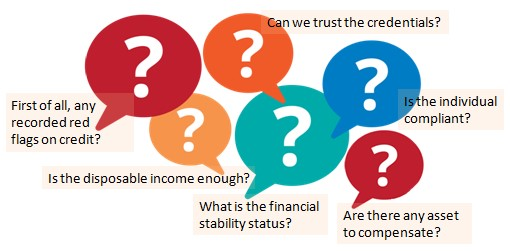

(I'm not claiming that this is right, but for me, this makes sense.)

During field inspection, I'll try to comprehend whether a certain field falls on any of these questions. It can serve as a guide on how we deal with a certain feature. Below are excel sheet snippets of the initial sorting that I made on all the fields (please see TAG column).

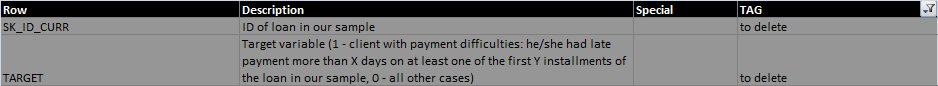

Decisions:
* 'SK_ID_CURR' is just the loan ID which is unique for every individual. It will not contribute to the prediction algorithm. --> DROP
* The 'TARGET' variable is the one that we are trying to predict, so we will NOT use it as a feature.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop = ['SK_ID_CURR']

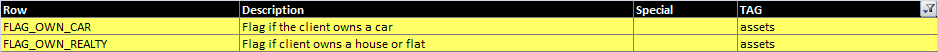

In [ ]:
tempY=df_train[df_train.FLAG_OWN_CAR=='Y']
tempN=df_train[df_train.FLAG_OWN_CAR=='N']
tempY_targ1=tempY[tempY.TARGET==1]
tempN_targ1=tempN[tempN.TARGET==1]

In [ ]:
print('People count who owns a car:',len(tempY),'(',round(len(tempY)/len(df_train.index)*100,2),'%)')
print('People count who DOES NOT own a car:',len(tempN),'(',round(len(tempN)/len(df_train.index)*100,2),'%)')
print('Percentage of people who defaulted (with cars):',round(len(tempY_targ1)/len(tempY)*100,2),'%')
print('Percentage of people who defaulted (no cars):',round(len(tempN_targ1)/len(tempN)*100,2),'%')

In [ ]:
tempY=df_train[df_train.FLAG_OWN_REALTY=='Y']
tempN=df_train[df_train.FLAG_OWN_REALTY=='N']
tempY_targ1=tempY[tempY.TARGET==1]
tempN_targ1=tempN[tempN.TARGET==1]

In [ ]:
print('People count who owns realty:',len(tempY),'(',round(len(tempY)/len(df_train.index)*100,2),'%)')
print('People count who DOES NOT own realty:',len(tempN),'(',round(len(tempN)/len(df_train.index)*100,2),'%)')
print('Percentage of people who defaulted (with realty):',round(len(tempY_targ1)/len(tempY)*100,2),'%')
print('Percentage of people who defaulted (no realty):',round(len(tempN_targ1)/len(tempN)*100,2),'%')

Observations:
* It's a small difference but it looks like people with no car and/or realty tend to default more than those who have. 

Decisions:
* I'll be converting these 2 categorical fields into one nominal field called 'assets'.

In [ ]:
# CREATE NEW COLUMN : 0 - none, 1 - with car no realty, 2 - no car with realty, 3 - with car with realty
list_col_new_asset = ['FLAG_OWN_CAR','FLAG_OWN_REALTY'] 

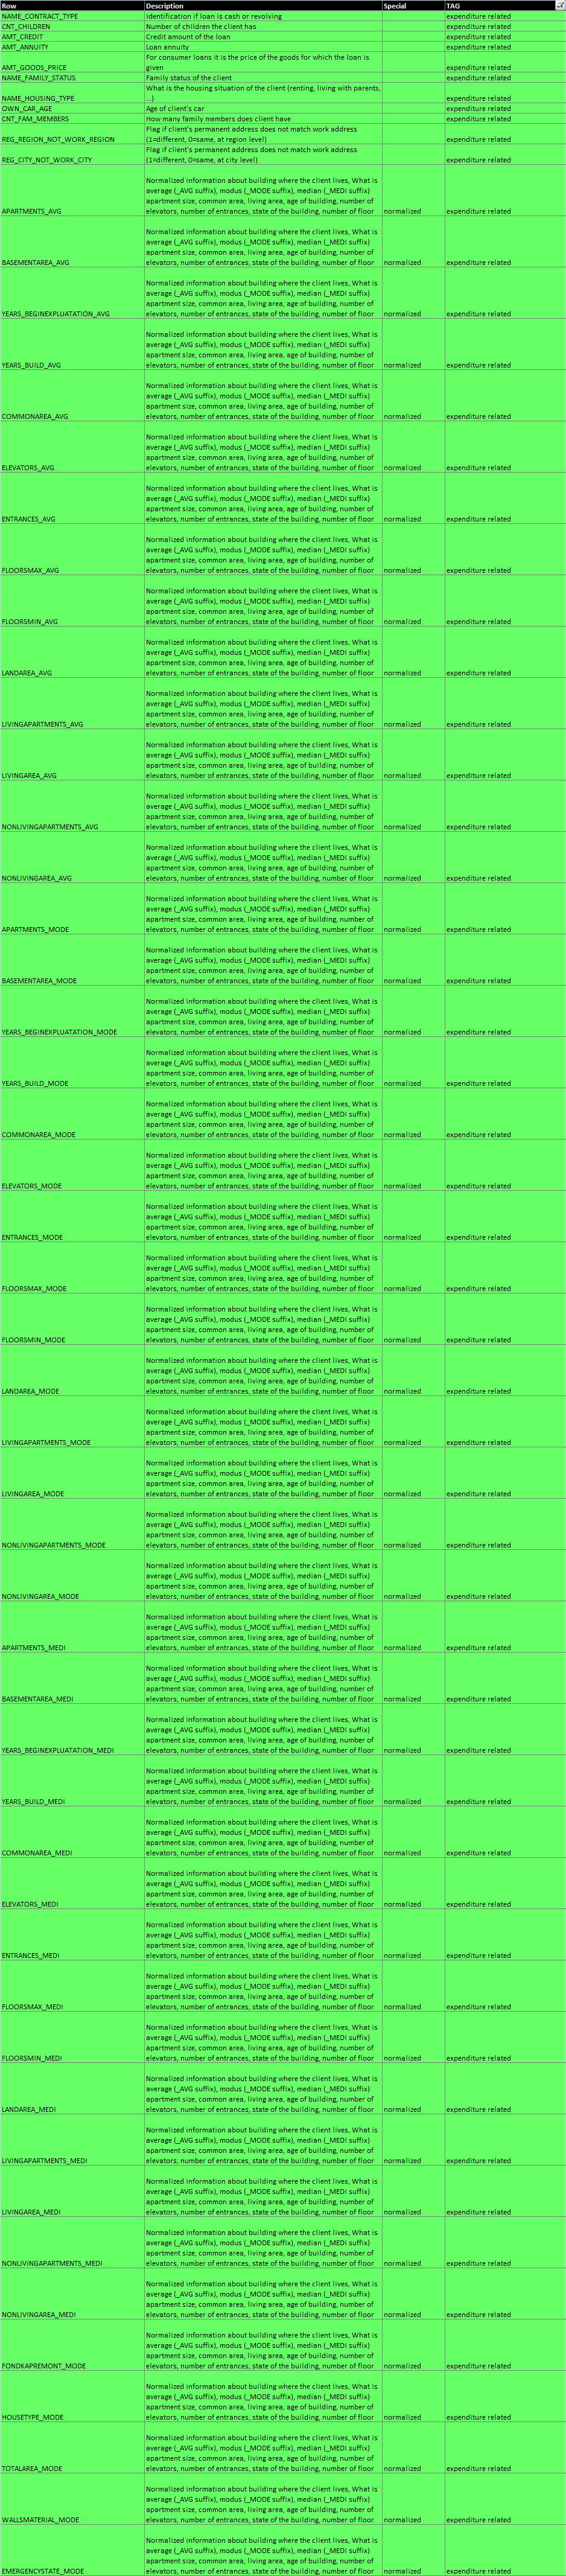

The expenditure-related set is quite a lot. We can break it down base on the fields' relatedness.

Expenditure-related: THE LOAN ITSELF.

In [ ]:
sns.pairplot(df_train[['NAME_CONTRACT_TYPE','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']],hue='NAME_CONTRACT_TYPE');

In [ ]:
corr1=round(df_train.AMT_CREDIT.corr(df_train.AMT_GOODS_PRICE),2)
corr2=round(df_train.AMT_ANNUITY.corr(df_train.AMT_CREDIT),2)
corr3=round(df_train.AMT_ANNUITY.corr(df_train.AMT_GOODS_PRICE),2)

In [ ]:
print('Correlation of Credit amount vs Price of goods:',corr1)
print('Correlation of Annuity amount vs Credit amount:',corr2)
print('Correlation of Annuity amount vs Price of goods:',corr3)

In [ ]:
cash=df_train[df_train.NAME_CONTRACT_TYPE == 'Cash loans']
rev=df_train[df_train.NAME_CONTRACT_TYPE == 'Revolving loans']
def_cash=cash[cash.TARGET==1]
def_rev=rev[rev.TARGET==1]

In [ ]:
print('Percentage of defaulted cash loan:',round(len(def_cash)/len(cash)*100,2,),'%')
print('Percentage of defaulted revolving loan:',round(len(def_rev)/len(rev)*100,2),'%')
sns.catplot(data=df_train,x='NAME_CONTRACT_TYPE',hue='TARGET',kind='count');

Observations:
* AMT_CREDIT and AMT_GOODS_PRICE are highly correlated (scoring 0.99!), and has a positive linear slope - which makes sense because as the price of goods for which the loan is given gets higher, the credit amount of the loan (ofcourse) gets higher too.
* AMT_ANNUITY is also highly correlated to AMT_CREDIT and AMT_GOODS_PRICE with a positive linearity. It's because the annuity is the monthly due amount.
* NAME_CONTRACT_TYPE: Accounting for those who defaulted is much bigger in terms of cash loan than those with revolving loan, however, we must note that cash loan is *significantly* more popular to our sample consumers than the other. 

Decisions:
* AMT_GOODS_PRICE - to drop as it is quite redundant. We already have the AMT_CREDIT field to account for the loan amount.
* AMT_ANNUITY - create new feature PERCENT_ANNUITY_INCOME to indicate the loan annuity amount relative to the person's total income.
* AMT_CREDIT - create new feature PERCENT_CREDIT_INCOME to indicate the loan credit amount relative to the person's total income.
* NAME_CONTRACT_TYPE - to drop since the defaulting rate for both loan type has less than 3% difference. We can focus more on the person's percentage of annuity or credit amount relative to their income.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['NAME_CONTRACT_TYPE','AMT_GOODS_PRICE'])

# CREATE NEW COLUMN : PERCENT_ANNUITY_INCOME
list_col_new_annuity = ['AMT_ANNUITY','AMT_INCOME_TOTAL']

# CREATE NEW COLUMN : CREDIT_ANNUITY_INCOME
list_col_new_credit = ['AMT_CREDIT','AMT_INCOME_TOTAL']

Expenditure-related: SIZE OF HOUSEHOLD

In [ ]:
sns.catplot(data=df_train,x='NAME_FAMILY_STATUS',hue='TARGET',kind='count');
plt.xticks(rotation=90);

In [ ]:
df_train[['CNT_CHILDREN','NAME_FAMILY_STATUS','CNT_FAM_MEMBERS']][df_train.NAME_FAMILY_STATUS=='Married'].tail()

Observations:
* We have a large number of married customers in our sample population. The married set also contains the most frequent defaulting individuals.
* 'CNT_CHILDREN', 'NAME_FAMILY_STATUS', 'CNT_FAM_MEMBERS' are all related to family size. And if we only want to consider the family size for approximation of expenditures, we already have 'CNT_FAM_MEMBERS' wherein it accounts for the customer itself, plus spouse (if any), plus number of children (if any).

Decisions:
* Use 'CNT_FAM_MEMBER' as a feature model. Fill in missing values.
* Drop 'CNT_CHILDREN' and 'NAME_FAMILY_STATUS'.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['CNT_CHILDREN', 'NAME_FAMILY_STATUS'])

# COMPLETE COLUMN : 
list_col_fill_fam = ['CNT_FAM_MEMBERS']

Expenditure-related: TRAVEL

In [ ]:
corr1=round(df_train.OWN_CAR_AGE.corr(df_train.TARGET),2)
corr2=round(df_train.REG_REGION_NOT_WORK_REGION.corr(df_train.TARGET),2)
corr3=round(df_train.REG_CITY_NOT_WORK_CITY.corr(df_train.TARGET),2)
no_car,yes_car = df_train.FLAG_OWN_CAR.value_counts()

In [ ]:
print('Correlation of Age of Car vs Target:',corr1)
print('Correlation of Registered Region aint Work Region vs Target:',corr2)
print('Correlation of Registered City aint Work City vs Target:',corr3)

In [ ]:
df_train[['OWN_CAR_AGE','REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY']].describe()

In [ ]:
print('How many customers own a car? :',yes_car)
print('How many customers do NOT own a car? :',no_car)
print('How many missing values on OWN_CAR_AGE? :',df_train.OWN_CAR_AGE.isnull().sum())

Observations:
* We have a low correlation between these travel-related fields and the target variable.
* The number of missing values on 'OWN_CAR_AGE' is almost == number of customers who do NOT own a car -- which CAUSES the field to have missing values.

Decisions:
* Drop REG_REGION_NOT_WORK_REGION and REG_CITY_NOT_WORK_CITY as there is low correlation wrt TARGET variable.
* Create new ordinal category 'Car Expenditure' from a continuous numerical feature 'OWN_CAR_AGE'. Perhaps the older the car, the higher the maintenance expenditure.

In [ ]:
# CREATE NEW COLUMN : EXPENDITURE_CAR : 0 - no car, +=1 per age band
list_col_new_car = ['OWN_CAR_AGE']

# COLUMNS TO BE DROPPED
list_col_drop.extend(['REG_REGION_NOT_WORK_REGION','REG_CITY_NOT_WORK_CITY'])

Expenditure-related: RESIDENCE

In [ ]:
temp = ['NAME_HOUSING_TYPE',
        'APARTMENTS_AVG',
        'BASEMENTAREA_AVG',
        'YEARS_BEGINEXPLUATATION_AVG',
        'YEARS_BUILD_AVG',
        'COMMONAREA_AVG',
        'ELEVATORS_AVG',
        'ENTRANCES_AVG',
        'FLOORSMAX_AVG',
        'FLOORSMIN_AVG',
        'LANDAREA_AVG',
        'LIVINGAPARTMENTS_AVG',
        'LIVINGAREA_AVG',
        'NONLIVINGAPARTMENTS_AVG',
        'NONLIVINGAREA_AVG',
        'APARTMENTS_MODE',
        'BASEMENTAREA_MODE',
        'YEARS_BEGINEXPLUATATION_MODE',
        'YEARS_BUILD_MODE',
        'COMMONAREA_MODE',
        'ELEVATORS_MODE',
        'ENTRANCES_MODE',
        'FLOORSMAX_MODE',
        'FLOORSMIN_MODE',
        'LANDAREA_MODE',
        'LIVINGAPARTMENTS_MODE',
        'LIVINGAREA_MODE',
        'NONLIVINGAPARTMENTS_MODE',
        'NONLIVINGAREA_MODE',
        'APARTMENTS_MEDI',
        'BASEMENTAREA_MEDI',
        'YEARS_BEGINEXPLUATATION_MEDI',
        'YEARS_BUILD_MEDI',
        'COMMONAREA_MEDI',
        'ELEVATORS_MEDI',
        'ENTRANCES_MEDI',
        'FLOORSMAX_MEDI',
        'FLOORSMIN_MEDI',
        'LANDAREA_MEDI',
        'LIVINGAPARTMENTS_MEDI',
        'LIVINGAREA_MEDI',
        'NONLIVINGAPARTMENTS_MEDI',
        'NONLIVINGAREA_MEDI',
        'FONDKAPREMONT_MODE',
        'HOUSETYPE_MODE',
        'TOTALAREA_MODE',
        'WALLSMATERIAL_MODE',
        'EMERGENCYSTATE_MODE']

In [ ]:
# Nullity by column
msno.bar(df_train[temp],figsize=(20,5));

In [ ]:
msno.heatmap(df_train[temp],fontsize=12);

This heatmap above shows the correlation of those fields with null values: how strongly the presence or absence of one variable affects the presence of another.

* 1 : positive correlation (blue) >> if a variable appears, the other variable definitely does too.
* 0 : zero correlation (white) >> variables appearing or not appearing have no effect on one another.
* -1 : negative correlation (red) >> if a variable appears, the other variable definitely does NOT.

(BTW, so thankful I stumbled upon this awesome package for missing values! Check it out [here](http://github.com/ResidentMario/missingno)!)

In [ ]:
for i in ['APARTMENTS_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG','NONLIVINGAREA_MEDI']:
    temp=df_train[['NAME_HOUSING_TYPE']][df_train[i].isnull()]
    sns.catplot(data=temp,x='NAME_HOUSING_TYPE',kind='count',palette="rocket")
    plt.xticks(rotation=20)
    title = 'Housing Types with null values on ' + i
    plt.title(title)

Observations:
* Every unit/size-related field starting from 'APARTMENTS_AVG' till 'WALLSMATERIAL_MODE' are highly correlated with each other, with no value less than 0.7.
* I've plotted 4 sample features of these normalized information on where the customer lives, and it seems that the missing values are mostly coming from 'houses/apartments' -- take note, the 'rented' apartment is a different type (with it having a low count of missing values). Come to think of it, if we are living in a house for so long, we usually don't bother knowing its floor size or maybe we've forgotten about it - which is very much understandable. (unless you are going to renovate, rent-out or sell the place!) 
* The housing type that scored second highest with null values is 'with parents', and again it is common that someone living with parents won't actually bother knowing the land and floor area of their current residence. (from where I come from, this is usually the case)

Decisions:
* Since these are all residence-related sizes, I will consolidate them into one field to account for 'house expenditures'.

In [ ]:
# CREATE NEW COLUMN : EXPENDITURE_HOUSE 
list_col_new_house = ['NAME_HOUSING_TYPE',
                    'APARTMENTS_AVG',
                    'BASEMENTAREA_AVG',
                    'YEARS_BEGINEXPLUATATION_AVG',
                    'YEARS_BUILD_AVG',
                    'COMMONAREA_AVG',
                    'ELEVATORS_AVG',
                    'ENTRANCES_AVG',
                    'FLOORSMAX_AVG',
                    'FLOORSMIN_AVG',
                    'LANDAREA_AVG',
                    'LIVINGAPARTMENTS_AVG',
                    'LIVINGAREA_AVG',
                    'NONLIVINGAPARTMENTS_AVG',
                    'NONLIVINGAREA_AVG',
                    'APARTMENTS_MODE',
                    'BASEMENTAREA_MODE',
                    'YEARS_BEGINEXPLUATATION_MODE',
                    'YEARS_BUILD_MODE',
                    'COMMONAREA_MODE',
                    'ELEVATORS_MODE',
                    'ENTRANCES_MODE',
                    'FLOORSMAX_MODE',
                    'FLOORSMIN_MODE',
                    'LANDAREA_MODE',
                    'LIVINGAPARTMENTS_MODE',
                    'LIVINGAREA_MODE',
                    'NONLIVINGAPARTMENTS_MODE',
                    'NONLIVINGAREA_MODE',
                    'APARTMENTS_MEDI',
                    'BASEMENTAREA_MEDI',
                    'YEARS_BEGINEXPLUATATION_MEDI',
                    'YEARS_BUILD_MEDI',
                    'COMMONAREA_MEDI',
                    'ELEVATORS_MEDI',
                    'ENTRANCES_MEDI',
                    'FLOORSMAX_MEDI',
                    'FLOORSMIN_MEDI',
                    'LANDAREA_MEDI',
                    'LIVINGAPARTMENTS_MEDI',
                    'LIVINGAREA_MEDI',
                    'NONLIVINGAPARTMENTS_MEDI',
                    'NONLIVINGAREA_MEDI',
                    'FONDKAPREMONT_MODE',
                    'HOUSETYPE_MODE',
                    'TOTALAREA_MODE',
                    'WALLSMATERIAL_MODE',
                    'EMERGENCYSTATE_MODE']

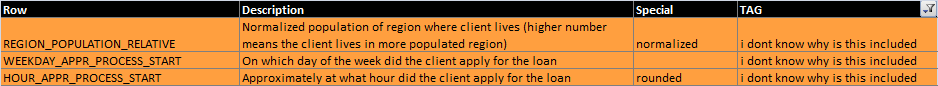

In [ ]:
fig,ax = plt.subplots(figsize=(10,7))
sns.countplot(data=df_train,x='REGION_POPULATION_RELATIVE',hue='TARGET',ax=ax);
plt.xticks(rotation=90)
plt.show()

In [ ]:
sns.catplot(data=df_train,x='WEEKDAY_APPR_PROCESS_START',hue='TARGET',kind='count');
plt.xticks(rotation=90);

In [ ]:
fig,ax = plt.subplots(figsize=(10,3))
sns.countplot(data=df_train,x='HOUR_APPR_PROCESS_START',hue='TARGET',ax=ax);
plt.xticks(rotation=90)
plt.show()

Observations:
* REGION_POPULATION_RELATIVE has min val = 0.00029 and max val = 0.072508. Normalized values usually range from 0 to 1, but for this sample, the maximum value is way too far from 1. Whatever values this may serve, there is a noticeable number of defaults as the value gets higher. 
* Majority of the customers apply during weekdays, with a few on weekends. The trend on customers who weren't able to repay the loan is similar with that of those who did. 
* Suspiciously, there are people applying for a loan account as early as 3am, and it gets denser throughout the day. Do note that those who defaulted on their loan has a similar pattern with those having good records.

Decisions:
* Use REGION_POPULATION_RELATIVE as a feature model. The larger the population on a certain region, the more chances of getting a customer with a bad record.
* Drop WEEKDAY_APPR_PROCESS_START. I can't say that there's little chance of defaulting if the customer opens an account during Sundays, because the account opening overall on that day is relatively low compared to other days.
* Drop HOUR_APPR_PROCESS_START. Similar reasoning with above.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START'])

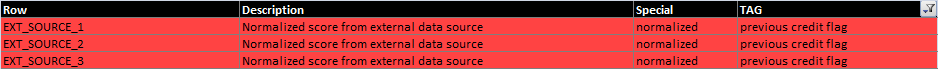

In [ ]:
temp=df_train[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
print(temp.info())
sns.pairplot(temp,hue='TARGET');

Observations: 
* These 3 fields are external data source score fields.
* Base on the plot above, those who were able to pay and did not pay can have scores fairly distributed on EXT_SOURCE fields, but it is quite evident that on the lower end of the normalized score mark (0.0-0.5), customers who paid (target=0, blue color) are much less prominent than those who didn't (target=1, orange color)... and vice versa.
* All 3 fields have missing values.

Decisions:
* Use EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 as model features. 
* Complete the fields by filling up the null values base on their mean EXT_SOURCE.

In [ ]:
# COMPLETE COLUMNS : Base on mean EXT_SOURCE
list_col_fill_ext = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

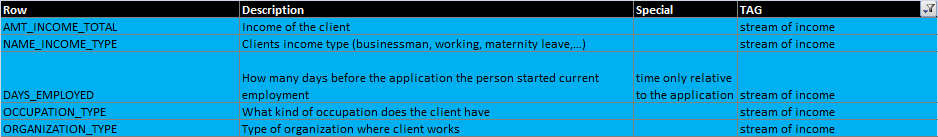

In [ ]:
df_train[['AMT_INCOME_TOTAL','NAME_INCOME_TYPE','DAYS_EMPLOYED','OCCUPATION_TYPE','ORGANIZATION_TYPE']].describe(include='all')

In [ ]:
def get_thresh(df,field):
    """ Outliers are usually > 3 standard deviations away from the mean. """
    ave=np.mean(df[field])
    sdev=np.std(df[field])
    threshold=round(ave+(3*sdev),2)
    print('Threshold for',field,':',threshold)
    return threshold

In [ ]:
thresh_income = get_thresh(df_train,'AMT_INCOME_TOTAL')
anomaly_emp = int(df_train['DAYS_EMPLOYED'][df_train['DAYS_EMPLOYED']>0].unique())
temp_orig=df_train[['AMT_INCOME_TOTAL','DAYS_EMPLOYED']]
temp_no_outliers=df_train[['AMT_INCOME_TOTAL','DAYS_EMPLOYED']][(df_train.AMT_INCOME_TOTAL<thresh_income)&(df_train['DAYS_EMPLOYED']<=0)]
print('Anomalous data for DAYS_EMPLOYED :',anomaly_emp)

In [ ]:
def plotdist(df,f1,f2):
    f,axes = plt.subplots(1,2,figsize=(10,3))
    sns.distplot(df[[f1]],ax=axes[0]).set_title(f1)
    plt.xticks(rotation=75)

    sns.distplot(df[[f2]],ax=axes[1]).set_title(f2)
    plt.xticks(rotation=75)
    plt.tight_layout()

In [ ]:
# AMT_INCOME_TOTAL, DAYS_EMPLOYED --> ORIGINAL VALUE WITH OUTLIERS
plotdist(temp_orig,'AMT_INCOME_TOTAL','DAYS_EMPLOYED')

In [ ]:
# AMT_INCOME_TOTAL, DAYS_EMPLOYED --> OUTLIERS REMOVED
plotdist(temp_no_outliers,'AMT_INCOME_TOTAL','DAYS_EMPLOYED')

In [ ]:
# NUMBER OF INDIVIDUALS HAVING THE DAYS EMPLOYED ANOMALOUS DATA
len(df_train[df_train.DAYS_EMPLOYED==anomaly_emp])

In [ ]:
unpaid=df_train[df_train.TARGET==1]
sns.catplot(data=unpaid,x='NAME_INCOME_TYPE',kind='count');
plt.xticks(rotation=90);
plt.title('Income Stream of DEFAULTED LOANS');

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
sns.countplot(data=unpaid,x='ORGANIZATION_TYPE',ax=ax);
plt.xticks(rotation=90)
plt.title('Organization of people with DEFAULTED LOANS')
plt.show()

In [ ]:
def plotstrip(df,xval,yval,hueval,yfig):
    fig,ax = plt.subplots(figsize=(15,yfig))
    sns.stripplot(x=xval,y=yval,hue=hueval,data=df,alpha=0.5,jitter=0.8,dodge=True,ax=ax).set_title(yval);
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

In [ ]:
temp=df_train[df_train.OCCUPATION_TYPE.isnull()]
print('Individuals that left OCCUPATION_TYPE field blank:')
print(temp.NAME_INCOME_TYPE.value_counts())

In [ ]:
print('Individuals that left ORGANIZATION_TYPE field blank (Top 10 only):')
print(temp.ORGANIZATION_TYPE.value_counts().head(10))

In [ ]:
plotstrip(df_train[df_train.AMT_INCOME_TOTAL<thresh_income],'AMT_INCOME_TOTAL','NAME_INCOME_TYPE','TARGET',5)

In [ ]:
plotstrip(df_train[df_train.AMT_INCOME_TOTAL<thresh_income],'AMT_INCOME_TOTAL','OCCUPATION_TYPE','TARGET',10)

In [ ]:
plotstrip(df_train[df_train.AMT_INCOME_TOTAL<thresh_income],'AMT_INCOME_TOTAL','ORGANIZATION_TYPE','TARGET',20)

Observations:
* AMT_INCOME_TOTAL has an outlier. As per the data: the 75th percentile is equal to 202,500, while the maximum value is equal to a whopping 117,000,000; It is quite a big difference as it means that **75% of our customers** are already making a total income of **202,500 or below** - the remaining 25% has a total income higher than 202,500.
* AMT_INCOME_TOTAL has a wide range of values, from min val 25,650 to max val 117,000,000.
* DAYS_EMPLOYED is having inconsistent data. It contains negative values (since it is in the form of 'days' relative to the application), then suddenly there is one very big positive number (365243 days - which equates to 1000 years!) with a significant number of individuals having it.
* NAME_INCOME_TYPE: The 'working' category is the most dense in terms of low wage high default customers. We also have very few samples on 'unemployed', 'student', 'maternity leave' and 'businessman'. Interesting to see that the 'businessman' category has an above average total income and has a high chance that they will maintain good credit scoring.
* NAME_INCOME_TYPE 'Pensioner' is almost equal to the DAYS_EMPLOYED anomaly data count! And it is also almost equal to the ORGANIZATION_TYPE value 'XNA' ! It just means that the '1000 years' employment duration was made for retired people.
* OCCUPATION_TYPE has 31% of its values missing. Majority of the null OCCUPATION_TYPE are from pensioners (which totally makes sense), then other big chunks are from working people, commercial associate, state servant, etc. My take here is that the choices on occupation type field is limited which led these number of working people to leaving it blank.
* The ORGANIZATION_TYPE is pretty diverse regarding where do these customers work. But base on the histogram, the category where the defaulting individuals are dominant are those in Business Entity Type 3, self-employed, and XNA.

Decisions:
* AMT_INCOME_TOTAL: Create new feature 'IncomeBand' to convert into ordinal income band category.
* DAYS_EMPLOYED: Convert anomalous data 365243 days to -29200 days (equal to 80 yrs). I think it's safe to say that an individual is retired by then after working for 80 yrs. Create new feature 'years employed' to convert number of employed 'days' to 'years' for easier reading.
* OCCUPATION_TYPE: to drop. We can leverage on how much is their total stream of income and how they acquire it.
* NAME_INCOME_TYPE: to drop. We can usually identify if someone is working, or a student, or already retired, etc., base on the age and ORGANIZATION_TYPE.
* ORGANIZATION_TYPE: Convert categorical text to numerical. Use feature for modeling.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['OCCUPATION_TYPE','NAME_INCOME_TYPE'])

# CREATE NEW COLUMN : INCOME_BAND
list_col_new_income = ['AMT_INCOME_TOTAL'] 

# CONVERT COLUMN : 365243 to -29200 
list_col_conv_daysemp = ['DAYS_EMPLOYED']

# CREATE NEW COLUMN : YEARS_EMPLOYED
list_col_new_yrsemp = ['DAYS_EMPLOYED']

# CONVERT COLUMN : 
list_col_conv_org = ['ORGANIZATION_TYPE'] 

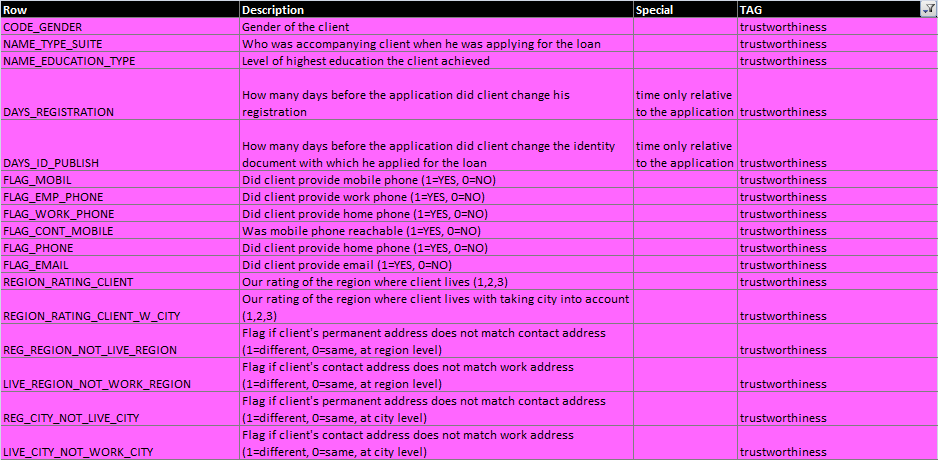

And for the final set of variables, I tagged it as 'trustworthiness' to account for trusthworthy credentials, or environmental/ unconsious factors that may shape an individual's behavior. It is quite a lot, so let's break it down again per function. (Note: the excel sheet above is incomplete as this notebook keeps crashing whenever I paste the remaining fields)

In [ ]:
df_train[['CODE_GENDER','NAME_TYPE_SUITE','NAME_EDUCATION_TYPE','DAYS_REGISTRATION','DAYS_ID_PUBLISH']].describe(include='all')

In [ ]:
g = sns.FacetGrid(df_train,row='CODE_GENDER',col='NAME_EDUCATION_TYPE',hue='TARGET',height=4) # nominal
g.map(plt.scatter,'DAYS_ID_PUBLISH','DAYS_REGISTRATION',alpha=0.5,edgecolor='k',linewidth=0.5) # continuous

fig = g.fig 
fig.set_size_inches(25,10)
fig.subplots_adjust(top=0.85,wspace=0.3)
fig.suptitle('Gender - Educational Attainment - Registration Change - ID Change - Credit Ranking',fontsize=20)

l = g.add_legend(title='Credit Score')

In [ ]:
paid = df_train[df_train.TARGET==0]
unpaid = df_train[df_train.TARGET==1]

f,axes = plt.subplots(1,2,figsize=(10,3))
sns.kdeplot(paid['DAYS_ID_PUBLISH'],paid['DAYS_REGISTRATION'],cmap="Blues",shade=True,shade_lowest=False,ax=axes[0]).set_title('Paid');
sns.kdeplot(unpaid['DAYS_ID_PUBLISH'],unpaid['DAYS_REGISTRATION'],cmap="Reds",shade=True,shade_lowest=False,ax=axes[1]).set_title('Unpaid');
sns.set_style('whitegrid')
plt.tight_layout()

In [ ]:
df_train.NAME_EDUCATION_TYPE.value_counts()

In [ ]:
f,axes = plt.subplots(1,2,figsize=(10,5),sharex=True)
sns.distplot(df_train[['DAYS_BIRTH']][df_train.TARGET==0],hist=False,color="b",kde_kws={"shade":True},ax=axes[0]).set_title('Target == 0 (Paid)');
sns.distplot(df_train[['DAYS_BIRTH']][df_train.TARGET==1],hist=False,color="r",kde_kws={"shade":True},ax=axes[1]).set_title('Target == 1 (Unpaid)');

Observations:
* We have 3 types of CODE_GENDER in our sample: Male, female and XNA. Male and female customers are pretty dense, both having same chances of defaulting relative to their total count. We have a very small set of XNA (non-binary?) people, and base on our sample, 100% of them have good credit record.
* For NAME_EDUCATION_TYPE, majority of our customers - whether male, female, or XNA - are having 'secondary special' or 'higher education', and most of the defaulting customers came from this educational background. 'Incomplete higher' and 'Lower secondary' are lesser with also less defaulting customers. And the least count are those with 'Academic degree' which got the least number of unpaid customers.
* The number of days in which the customer changed his/her identity document and/or application registration seemed to have the same pattern for those having good credit and bad credit. 
* The DAYS_BIRTH of a customer (or rather the 'age') seem as expected. We can note that the x-axis values are negative - because it is recorded relative prior to the loan application - and very high (because it is in 'days' format rather than in 'years'). As per the graph, younger people tend to default more. As people gets older, they seem to be able to have a higher chance of paying off the loan.

Decisions:
* Use CODE_GENDER as a model feature. Convert the categorical text to numeric.
* Use NAME_EDUCATION_TYPE as a model feature. Convert the categorical text to numeric.
* Drop DAYS_REGISTRATION, DAYS_ID_PUBLISH, NAME_TYPE_SUITE. I generated a KDE plot and I hardly see the difference.
* Create new feature 'age' from DAYS_BIRTH. Compute for the age in years rather than using the day count.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['NAME_TYPE_SUITE','DAYS_REGISTRATION','DAYS_ID_PUBLISH'])

# CONVERT COLUMN : 
list_col_conv_gender = ['CODE_GENDER']

# CONVERT COLUMN :
list_col_conv_edu = ['NAME_EDUCATION_TYPE']

# CREATE NEW COLUMN : AGE
list_col_new_age = ['DAYS_BIRTH']


In [ ]:
temp1=['FLAG_MOBIL',
'FLAG_EMP_PHONE',
'FLAG_WORK_PHONE',
'FLAG_CONT_MOBILE',
'FLAG_PHONE',
'FLAG_EMAIL']

temp2=['FLAG_DOCUMENT_2',
'FLAG_DOCUMENT_3',
'FLAG_DOCUMENT_4',
'FLAG_DOCUMENT_5',
'FLAG_DOCUMENT_6',
'FLAG_DOCUMENT_7',
'FLAG_DOCUMENT_8',
'FLAG_DOCUMENT_9',
'FLAG_DOCUMENT_10',
'FLAG_DOCUMENT_11',
'FLAG_DOCUMENT_12',
'FLAG_DOCUMENT_13',
'FLAG_DOCUMENT_14',
'FLAG_DOCUMENT_15',
'FLAG_DOCUMENT_16',
'FLAG_DOCUMENT_17',
'FLAG_DOCUMENT_18',
'FLAG_DOCUMENT_19',
'FLAG_DOCUMENT_20',
'FLAG_DOCUMENT_21']

In [ ]:
df_train[temp1+temp2].describe()

In [ ]:
def featsum(cols,newcol):
    """ Sums up items per row across all columns.
        Returns df with new sum column and catplot.
    """
    sample_count=df_train[cols].sum(axis=1)
    sample = df_train.copy()
    sample[newcol]=sample_count
    sns.catplot(data=sample,x=newcol,hue='TARGET',kind='count');

In [ ]:
featsum(temp1,'FlagContact')

In [ ]:
featsum(temp2,'FlagDocu')

Observations:
* All 26 'FLAG-' (flag for contacts and documents) variables have nominal categorical values: 1='YES', 0='NO'. 

Decisions:
* Create new feature 'FlagContact' to account for the total flag-contact variable recorded per individual. 
* Create new feature 'FlagDocu' to account for the total flag-document variable recorded per individual.

In [ ]:
# CREATE NEW COLUMN : FLAG_CONTACTS
list_col_new_flagCont = [ 
    'FLAG_MOBIL',
    'FLAG_EMP_PHONE',
    'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_PHONE',
    'FLAG_EMAIL']

# CREATE NEW COLUMN : FLAG_DOCS
list_col_new_flagDoc = [ 
    'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21']

In [ ]:
def plotcat(x,r):
    sns.catplot(data=df_train,x=x,hue='TARGET',kind='count');
    plt.xticks(rotation=r);

In [ ]:
plotcat('REGION_RATING_CLIENT',0)

In [ ]:
plotcat('REGION_RATING_CLIENT_W_CITY',0)

In [ ]:
print('Correlation:',round(df_train['REGION_RATING_CLIENT_W_CITY'].corr(df_train['REGION_RATING_CLIENT']),2))

In [ ]:
temp=[
    'REG_REGION_NOT_LIVE_REGION',
    'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY',
    'LIVE_CITY_NOT_WORK_CITY'
]

In [ ]:
featsum(temp,'FlagAddr')

Observations:
* REGION_RATING_CLIENT & REGION_RATING_CLIENT_W_CITY is highly correlated, scoring 0.95. This is Home Credit's rating of the region where client lives (values = 1,2,3). Majority of the sample obtains a value of '2', and the defaulting count is visible 
* The 4 fields related to flags if the customer's certain (registered) address does not match another given address, the values being: 0='SAME', 1='DIFFERENT'. Most of the customers registered their addresses accurately (scoring 0). And since '0' has a very high frequency, there is a greater chance of encountering different kinds of people that may default on their loan. 

Decisions:
* Use REGION_RATING_CLIENT as a feature model.
* Drop REGION_RATING_CLIENT_W_CITY since it is highly correlated to region rating alone.
* Create new ordinal feature 'flag address' to indicate the sum of all 4 flag-address-related fields. The higher the score, the more inaccurate address declarations were made by the individual.


In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['REGION_RATING_CLIENT_W_CITY'])

# CREATE NEW COLUMN : FLAG_ADDR
list_col_new_flagAddr = ['REG_REGION_NOT_LIVE_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY','LIVE_CITY_NOT_WORK_CITY']

In [ ]:
df_train[['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE']].describe()

In [ ]:
def featsumviolin(df,cols1,cols2,newcol1,newcol2):
    """ Sums up items per row across all columns.
        Returns df with new sum column and violinplot.
    """
    sample_count1=df[cols1].sum(axis=1)
    sample_count2=df[cols2].sum(axis=1)
    sample = df_train.copy()
    sample[newcol1]=sample_count1
    sample[newcol2]=sample_count2
    fig,ax = plt.subplots(figsize=(10,5))
    sns.violinplot(data=sample,hue='TARGET',x=newcol1,y=newcol2,split=True,inner='quart',linewidth=1.3,palette={1:"#FF9999", 0:"white"});

In [ ]:
featsumviolin(df_train[(df_train.OBS_30_CNT_SOCIAL_CIRCLE<348)&(df_train.OBS_60_CNT_SOCIAL_CIRCLE<344)],
              ['DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE'],
              ['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE'],
              'DEF_NEW','OBS_NEW')

In [ ]:
sns.set(palette="muted",color_codes=True)
f,axes = plt.subplots(2,2,figsize=(10,5),sharex=True)

sns.distplot(df_train[['DAYS_LAST_PHONE_CHANGE']][df_train.TARGET==0],kde=False,color="b",ax=axes[0,0]).set_title('Target == 0 (Paid)')
sns.distplot(df_train[['DAYS_LAST_PHONE_CHANGE']][df_train.TARGET==0],hist=False,color="g",kde_kws={"shade":True},ax=axes[0,1]).set_title('Target == 0 (Paid)')

sns.distplot(df_train[['DAYS_LAST_PHONE_CHANGE']][df_train.TARGET==1],kde=False,color="r",ax=axes[1,0]).set_title('Target == 1 (Unpaid)')
sns.distplot(df_train[['DAYS_LAST_PHONE_CHANGE']][df_train.TARGET==1],hist=False,color="m",kde_kws={"shade":True},ax=axes[1,1]).set_title('Target == 1 (Unpaid)')

plt.tight_layout()

Observations:
* There are 2 variables related to 30 days past due (30 DPD), and another 2 for 60 days past due (60 DPD). I have combined them and plotted using a violinplot as seen above. From what I understand here, those people that defaulted, and even those who didn't, have equal possibilities of missing a payment on their due date. Though surprisingly, majority of those who paid on a much later date got their loans cleared off.
> Note: A payment status of 30-days late means that payment is between 30-59 days past the payment due date (30 DPD). A payment status of 60-days late means that payment is between 60-89 days past the payment due date (60 DPD).
* I plotted separately the days in which a customer last changed their phone (relative to their application) for those having good and bad loan status records. The result is pretty much expected, as most people tend to change phones in a span of 2-3 years only (hence the distribution is skewed to the right). We can see that the people count gets lesser and lesser as the usage of their phone gets longer than the average.

Decisions:
* Drop the DPD variables.
* Drop DAYS_LAST_PHONE_CHANGE.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['OBS_30_CNT_SOCIAL_CIRCLE','DEF_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE','DAYS_LAST_PHONE_CHANGE'])

And finally, for the last set of variables to be explored: Number of enquiries to Credit Bureau about the customer.

In [ ]:
df_train[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']].describe()

In [ ]:
for i in ['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK']:
    for j in ['AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']:
        fig,ax = plt.subplots(figsize=(10,3))
        sns.stripplot(data=df_train[df_train.AMT_REQ_CREDIT_BUREAU_QRT<261],x=i,y=j,hue='TARGET',alpha=0.5,jitter=0.3,dodge=True,ax=ax)
        plt.show()

Observations:
* What I can see here is that, majority of the sample don't really have queries (0.0) regardless what time period it is, and regardless of their repayment status. The most common enquiry count ranges from 0 to 2, but then the behavior is similar to both TARGET==0 and TARGET==1. Do take note that we only have a few individuals (about 8%) in our sample population that defaulted (TARGET==1).

Decisions:
* Drop the credit bureau enquiry fields.

In [ ]:
# COLUMNS TO BE DROPPED
list_col_drop.extend(['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR'])

<a id='wrangling'></a>
# Data Wrangling

After (finally) checking all our fields, it is time to proceed with data wrangling - also known as the data cleaning process.

Complete the null values of the following features:
* 'EXT_SOURCE_1'
* 'EXT_SOURCE_2'
* 'EXT_SOURCE_3'

In [ ]:
def getmean(df,ls_cols):
    list_mean = []
    for i in ls_cols:
        mean_val = df[i].mean()
        list_mean.append(mean_val)
    return list_mean

def fill_ave_ext(df,ls_cols):  
    list_mean = getmean(df,ls_cols) # mean of EXT_SOURCE_*
    ctr=0
    for i in ls_cols:
        df[i] = df[i].fillna(list_mean[ctr])
        ctr+=1
    return df
        
# Fill in the training set
fill_ave_ext(df_train,list_col_fill_ext);

# Fill in the testing set
fill_ave_ext(df_test,list_col_fill_ext);

In [ ]:
# NO MORE NULL VALUES FOR 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'
print(df_train[list_col_fill_ext].info())
print(df_test[list_col_fill_ext].info())

Complete the null values for 'CNT_FAM_MEMBERS'.

In [ ]:
def fill_0_fam(df,ls_cols):
    df[ls_cols] = df[ls_cols].fillna(0)
    return df
    
    
fill_0_fam(df_train,'CNT_FAM_MEMBERS');
fill_0_fam(df_test,'CNT_FAM_MEMBERS');

In [ ]:
# NO MORE NULL VALUES FOR 'CNT_FAM_MEMBERS'
print(df_train[list_col_fill_fam].info())
print(df_test[list_col_fill_fam].info())

Convert the anomaly data in 'DAYS_EMPLOYED'.

In [ ]:
# ANOMALY DATA COUNT BEFORE CONVERSION
print('Train set :',len(df_train[df_train.DAYS_EMPLOYED==365243]))
print('Test set  :',len(df_test[df_test.DAYS_EMPLOYED==365243]))

In [ ]:
def conv_daysemp(df,ls_cols):
    df[ls_cols[0]].replace(to_replace=365243,value=-29200,inplace=True)
    return df

In [ ]:
conv_daysemp(df_train,list_col_conv_daysemp);
conv_daysemp(df_test,list_col_conv_daysemp);

In [ ]:
# ANOMALY DATA COUNT AFTER CONVERSION
print('Train set :',len(df_train[df_train.DAYS_EMPLOYED==365243]))
print('Test set  :',len(df_test[df_test.DAYS_EMPLOYED==365243]))

Convert the categorical text columns to numerical ones for:
* CODE_GENDER
* NAME_EDUCATION_TYPE
* ORGANIZATION_TYPE

In [ ]:
# BEFORE CONVERSION
print(df_train[['CODE_GENDER','NAME_EDUCATION_TYPE','ORGANIZATION_TYPE']].head(3))
print(df_test[['CODE_GENDER','NAME_EDUCATION_TYPE','ORGANIZATION_TYPE']].head(3))

In [ ]:
def conv_gender(df,ls_cols):
    df[ls_cols[0]] = df[ls_cols[0]].map({'XNA':0,'M':1,'F':2}).astype(int)
    return df

def conv_education(df,ls_cols):
    temp_dict = {
        'Lower secondary':1,
        'Secondary / secondary special':2,
        'Incomplete higher':3,
        'Higher education':4,
        'Academic degree':5
    }
    df[ls_cols[0]] = df[ls_cols[0]].map(temp_dict).astype(int)
    return df

def conv_org(df,ls_cols):
    ls_ctr=[i for i in np.arange(1,len(ls_cols)+1)]
    temp_dict = dict(zip(ls_cols,ls_ctr))
    df['ORGANIZATION_TYPE'] = df['ORGANIZATION_TYPE'].map(temp_dict).astype(int)
    return df

In [ ]:
conv_gender(df_train,list_col_conv_gender);
conv_gender(df_test,list_col_conv_gender);

conv_education(df_train,list_col_conv_edu);
conv_education(df_test,list_col_conv_edu);

In [ ]:
orgtype = sorted(df_train.ORGANIZATION_TYPE.unique())
conv_org(df_train,orgtype);
conv_org(df_test,orgtype);

In [ ]:
# AFTER CONVERSION
print(df_train[['CODE_GENDER','NAME_EDUCATION_TYPE','ORGANIZATION_TYPE']].head(3))
print(df_test[['CODE_GENDER','NAME_EDUCATION_TYPE','ORGANIZATION_TYPE']].head(3))

<a id='engineering'></a>
# Feature Engineering

Only few variables were processed at the data wrangling phase, mainly because most of it will be *engineered* to create new features from existing ones. Hopefully, this will improve the model performance. Let's start.


***On a side note, I've dropped some of the features that I previously considered due to my limited experience in feature engineering. I'd probably revisit this notebook in the future to further improve.***

In [ ]:
# CREATE NEW COLUMN : 0 - none, 1 - with car no realty, 2 - no car with realty, 3 - with car with realty
list_col_new_asset

In [ ]:
def create_asset(df):
    df['FLAG_ASSET'] = np.nan
    filter_0 = (df.FLAG_OWN_CAR=='N')&(df.FLAG_OWN_REALTY=='N')
    filter_1 = (df.FLAG_OWN_CAR=='Y')&(df.FLAG_OWN_REALTY=='N')
    filter_2 = (df.FLAG_OWN_CAR=='N')&(df.FLAG_OWN_REALTY=='Y')
    filter_3 = (df.FLAG_OWN_CAR=='Y')&(df.FLAG_OWN_REALTY=='Y')
    
    df['FLAG_ASSET'][filter_0] = 0
    df['FLAG_ASSET'][filter_1] = 1
    df['FLAG_ASSET'][filter_2] = 2
    df['FLAG_ASSET'][filter_3] = 3
    return df

    
create_asset(df_train);
create_asset(df_test);

In [ ]:
# SAMPLE OUTPUT
df_test[['FLAG_OWN_CAR','FLAG_OWN_REALTY','FLAG_ASSET']].head()

In [ ]:
# SINCE WE NOW HAVE AN ASSET INDICATOR, WE CAN NOW REMOVE list_col_new_asset 
list_col_drop.extend(list_col_new_asset)

In [ ]:
# CREATE NEW COLUMN : FLAG_CONTACTS
list_col_new_flagCont

In [ ]:
def create_sum_cols(df,ls_cols,newcol):
    """ Sums up items per row across all columns.
        Returns df with new sum column.
    """
    df[newcol] = np.nan
    ls_sum_value = df[ls_cols].sum(axis=1)
    df[newcol] = ls_sum_value
    return df

In [ ]:
create_sum_cols(df_train,list_col_new_flagCont,'FLAG_CONTACTS');
create_sum_cols(df_test,list_col_new_flagCont,'FLAG_CONTACTS');

In [ ]:
df_test[['FLAG_CONTACTS']].head()

In [ ]:
# CREATE NEW COLUMN : FLAG_DOCS
list_col_new_flagDoc

In [ ]:
create_sum_cols(df_train,list_col_new_flagDoc,'FLAG_DOCS');
create_sum_cols(df_test,list_col_new_flagDoc,'FLAG_DOCS');

In [ ]:
df_test[['FLAG_DOCS']].head()

In [ ]:
# CREATE NEW COLUMN : FLAG_ADDR
list_col_new_flagAddr

In [ ]:
create_sum_cols(df_train,list_col_new_flagAddr,'FLAG_ADDR');
create_sum_cols(df_test,list_col_new_flagAddr,'FLAG_ADDR');

In [ ]:
df_test[['FLAG_ADDR']].head()

In [ ]:
# SINCE WE NOW HAVE FLAG COMPLIANCE FIELDS, WE CAN NOW REMOVE EXISTING COLUMNS 
list_col_drop.extend(list_col_new_flagCont)
list_col_drop.extend(list_col_new_flagDoc)
list_col_drop.extend(list_col_new_flagAddr)

In [ ]:
# CREATE NEW COLUMN : AGE
list_col_new_age 

In [ ]:
def create_day_to_year(df,ls_cols,newcol):
    df[newcol] = round(np.abs(df[ls_cols[0]]/365))
    return df

In [ ]:
create_day_to_year(df_train,list_col_new_age,'AGE');
create_day_to_year(df_test,list_col_new_age,'AGE');

In [ ]:
f,ax=plt.subplots(figsize=(10,5))
sns.countplot(data=df_train[df_train.TARGET==1],x='AGE',hue='TARGET').set_title('Age of Individuals with default loans')
plt.xticks(rotation=90);

In [ ]:
# CREATE NEW COLUMN : YEARS_EMPLOYED
list_col_new_yrsemp

In [ ]:
create_day_to_year(df_train,list_col_new_yrsemp,'YEARS_EMPLOYED');
create_day_to_year(df_test,list_col_new_yrsemp,'YEARS_EMPLOYED');

In [ ]:
df_test[['YEARS_EMPLOYED']].head()

In [ ]:
# SINCE WE NOW HAVE NEW FEATURES, WE CAN NOW REMOVE EXISTING COLUMNS 
list_col_drop.extend(list_col_new_age)
list_col_drop.extend(list_col_new_yrsemp)

In [ ]:
# CREATE NEW COLUMN : INCOME_BAND
list_col_new_income

In [ ]:
# Create INCOME_BAND to group individuals per income range
def create_income_band(df):
    df.loc[(df.AMT_INCOME_TOTAL < 30000),'INCOME_BAND'] = 1
    df.loc[(df.AMT_INCOME_TOTAL >= 30000)&(df.AMT_INCOME_TOTAL < 65000),'INCOME_BAND'] = 2
    df.loc[(df.AMT_INCOME_TOTAL >= 65000)&(df.AMT_INCOME_TOTAL < 95000),'INCOME_BAND'] = 3
    df.loc[(df.AMT_INCOME_TOTAL >= 95000)&(df.AMT_INCOME_TOTAL < 130000),'INCOME_BAND'] = 4
    df.loc[(df.AMT_INCOME_TOTAL >= 130000)&(df.AMT_INCOME_TOTAL < 160000),'INCOME_BAND'] = 5
    df.loc[(df.AMT_INCOME_TOTAL >= 160000)&(df.AMT_INCOME_TOTAL < 190000),'INCOME_BAND'] = 6
    df.loc[(df.AMT_INCOME_TOTAL >= 190000)&(df.AMT_INCOME_TOTAL < 220000),'INCOME_BAND'] = 7
    df.loc[(df.AMT_INCOME_TOTAL >= 220000)&(df.AMT_INCOME_TOTAL < 275000),'INCOME_BAND'] = 8
    df.loc[(df.AMT_INCOME_TOTAL >= 275000)&(df.AMT_INCOME_TOTAL < 325000),'INCOME_BAND'] = 9
    df.loc[(df.AMT_INCOME_TOTAL >= 325000),'INCOME_BAND'] = 10
    return df

In [ ]:
create_income_band(df_train);
create_income_band(df_test);

In [ ]:
sns.countplot(data=df_train[df_train.TARGET==1],x='INCOME_BAND',hue='TARGET').set_title('Income of Individuals with default loans');

In [ ]:
# CREATE NEW COLUMN : PERCENT_ANNUITY_INCOME
list_col_new_annuity

In [ ]:
def create_perc(df,col1,col2,newcol):
    df[newcol] = round((df[col1]/df[col2])*100,2)
    df[newcol] = df[newcol].fillna(0)
    return df

In [ ]:
create_perc(df_train,'AMT_ANNUITY','AMT_INCOME_TOTAL','PERCENT_ANNUITY_INCOME');
create_perc(df_test,'AMT_ANNUITY','AMT_INCOME_TOTAL','PERCENT_ANNUITY_INCOME');

In [ ]:
df_test[['AMT_INCOME_TOTAL','AMT_ANNUITY','PERCENT_ANNUITY_INCOME']].head()

In [ ]:
# CREATE NEW COLUMN : PERCENT_CREDIT_INCOME
list_col_new_credit

In [ ]:
create_perc(df_train,'AMT_INCOME_TOTAL','AMT_CREDIT','PERCENT_CREDIT_INCOME');
create_perc(df_test,'AMT_INCOME_TOTAL','AMT_CREDIT','PERCENT_CREDIT_INCOME');

In [ ]:
df_test[['AMT_INCOME_TOTAL','AMT_CREDIT','PERCENT_CREDIT_INCOME']].head()

In [ ]:
# CREATE NEW COLUMN : EXP_CAR 
list_col_new_car

In [ ]:
# Create EXP_CAR to group car age
def create_car_band(df):
    df.loc[(df.OWN_CAR_AGE == 0 ),'EXP_CAR'] = 1
    df.loc[(df.OWN_CAR_AGE >= 1)&(df.OWN_CAR_AGE < 4),'EXP_CAR'] = 2
    df.loc[(df.OWN_CAR_AGE >= 4)&(df.OWN_CAR_AGE < 8),'EXP_CAR'] = 3
    df.loc[(df.OWN_CAR_AGE >= 8)&(df.OWN_CAR_AGE < 11),'EXP_CAR'] = 4
    df.loc[(df.OWN_CAR_AGE >= 11)&(df.OWN_CAR_AGE < 15),'EXP_CAR'] = 5
    df.loc[(df.OWN_CAR_AGE >= 15)&(df.OWN_CAR_AGE < 20),'EXP_CAR'] = 6
    df.loc[(df.OWN_CAR_AGE >= 20 ),'EXP_CAR'] = 7
    df['EXP_CAR'] = df['EXP_CAR'].fillna(0)
    return df

In [ ]:
create_car_band(df_train);
create_car_band(df_test);

In [ ]:
sns.countplot(data=df_train[df_train.TARGET==1],x='EXP_CAR',hue='TARGET').set_title('Car Age band of Individuals with default loans');

In [ ]:
# CREATE NEW COLUMN : EXP_HOUSE 
list_col_new_house;

In [ ]:
df_train[list_col_new_house].describe()

In [ ]:
list_col_new_house_copy = list_col_new_house.copy()
list_col_new_house_copy.extend(['TARGET'])
plt.subplots(figsize=(10,8))
sns.heatmap(df_train[list_col_new_house_copy].corr(),vmin=-1,vmax=1,cmap='BrBG');

In [ ]:
# DROP THE MEDIAN AND MODE APARTMENT MEASUREMENTS SINCE ALL ARE HIGHLY CORRELATED. CREATE ONE FEATURE FOR THE REMAINING AVG MEASUREMENT.
list_col_new_house_avg = list_col_new_house[0:14].copy()

In [ ]:
create_sum_cols(df_train,list_col_new_house_avg,'EXP_HOUSE');
create_sum_cols(df_test,list_col_new_house_avg,'EXP_HOUSE');

In [ ]:
df_test[['EXP_HOUSE']].head()

In [ ]:
# SINCE WE NOW HAVE NEW FEATURES, WE CAN NOW REMOVE EXSITING ONES 
list_col_drop.extend(list_col_new_income)  
list_col_drop.extend(list_col_new_annuity)
list_col_drop.extend(list_col_new_credit) 
list_col_drop.extend(list_col_new_car) 
list_col_drop.extend(list_col_new_house)  

We can now finally remove all the other unecessary columns.

In [ ]:
def remove_dups(x):
  return list(dict.fromkeys(x))

In [ ]:
print('Original column list count to drop:',len(list_col_drop)) #114

In [ ]:
list_col_drop_new = remove_dups(list_col_drop)

In [ ]:
print('Column list count to drop (duplicates removed):',len(list_col_drop_new)) #112

In [ ]:
# UPDATED DATAFRAME
df_train.drop(list_col_drop_new,axis=1,inplace=True)
df_test.drop(list_col_drop_new,axis=1,inplace=True)

# PRINT UPDATED DATAFRAME
df_train

In [ ]:
df_train.describe()

<a id='algorithm'></a>
# Model Training and Evaluation

In [ ]:
X = df_train.drop(columns='TARGET',axis=1)
y = df_train.TARGET

X_pred = df_test

In [ ]:
X

In [ ]:
X_pred

In [ ]:
import time
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
folds = StratifiedKFold(n_splits=5)
oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(X_pred.shape[0])

In [ ]:
start = time.time()
valid_score = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    trn_x, trn_y = X.iloc[trn_idx], y[trn_idx]
    val_x, val_y = X.iloc[val_idx], y[val_idx]    
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    param = {'application':'binary','num_iterations':4000, 'learning_rate':0.05, 'num_leaves':24, 'feature_fraction':0.8, 'bagging_fraction':0.9,
             'lambda_l1':0.1, 'lambda_l2':0.1, 'min_split_gain':0.01, 'early_stopping_round':100, 'max_depth':7, 'min_child_weight':40, 'metric':'auc'}
    lgb_es_model = lgb.train(param, train_data, valid_sets=[train_data, valid_data], verbose_eval=100) 
    
    oof_preds[val_idx] = lgb_es_model.predict(val_x, num_iteration=lgb_es_model.best_iteration)
    sub_preds += lgb_es_model.predict(X_pred, num_iteration=lgb_es_model.best_iteration) / folds.n_splits
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    valid_score += roc_auc_score(val_y, oof_preds[val_idx])

print('valid score:', str(round(valid_score/folds.n_splits,4)))

end = time.time()
print('training time:', str(round((end - start)/60)), 'mins')

In [ ]:
lgb.plot_importance(lgb_es_model, height=0.5, max_num_features=20, ignore_zero = False, figsize = (12,6), importance_type ='gain')

<a id='implementation'></a>
# Implementation

In [ ]:
# HOW TO REMOVE FILE
"""
if os.path.isfile('/kaggle/working/application_pred.csv'):
    os.remove('/kaggle/working/application_pred.csv')
    print("success")
else:    
    print("File doesn't exists!")
""";

In [ ]:
# PREDICT!
application_test= pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
output = pd.DataFrame({'SK_ID_CURR':application_test.SK_ID_CURR, 'TARGET': sub_preds})
output.to_csv('application_pred.csv', index=False)

That's all folks for this Home Credit Risk Classification project. Do leave a note for feedback and improvement. Thank you for reading and spending some time on this project. :-)